# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.datasets import make_classification

from helper.data_cleaning import clean_profile, clean_portfolio, join_coupon_profile_data, join_consumer_data
from helper.training import calc_coupon_x_consumer_data, run_predict_random_forest, run_predict_knn

## Prepare Training

We need to import the data that are from the dataset and from our previous analysis:

- `profile`, after running clean_profile function
- `portfolio`, after running clean_portfolio function
- `consumer_features`, where we created from our data analysis
- `consumer_sensitivity`, created from our visualization and analysis
- `target_created` from our data analysis

In [2]:
profile = clean_profile('assets/profile.json')
portfolio = clean_portfolio('assets/portfolio.json')

In [3]:
consumer_feature = pd.read_csv('training_data/consumer_features.csv', index_col='consumer_id')

consumer_sensitivity = pd.read_csv('training_data/consumer_sensitivity.csv', index_col='consumer_id')

target = pd.read_csv('training_data/target.csv', index_col='consumer_id')

In [4]:
# Calculate coupon 1 : ae264e3637204a6fb9bb56bc8210ddfd
coupon_0_consumer_data = calc_coupon_x_consumer_data(0, portfolio, profile, target, consumer_feature, consumer_sensitivity)
coupon_0_consumer_data

,ae264e3637204a6fb9bb56bc8210ddfd,Avg Daily spending,Highest daily spending,Lowest daily spending,count days no spending,count days spending 0_to_5,count days spending 5_to_10,count days spending 10_to_15,count days spending 15_to_20,count days spending 20_plus,...,110000-120000,120000-130000,ae264e3637204a6fb9bb56bc8210ddfd_type_sensitivity,4d5c57ea9a6940dd891ad53e9dbe8da0_type_sensitivity,9b98b8c7a33c4b65b9aebfe6a799e6d9_type_sensitivity,0b1e1539f2cc45b7b9fa7c272da2e1d7_type_sensitivity,2298d6c36e964ae4a3e7e9706d1fb8c2_type_sensitivity,fafdcd668e3743c1bb461111dcafc2a4_type_sensitivity,f19421c1d4aa40978ebb69ca19b0e20d_type_sensitivity,2906b810c7d4411798c6938adc9daaa5_type_sensitivity
consumer_id,,,,,,,,,,,,,,,,,,,,,
1722b68468334f8fa8ab22180b63d577,0,3.071000,25.34,13.33,25.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,-0.511833,-0.511833,-1.023667,-0.255917,-0.731190,-0.511833,-1.023667,-0.511833
ad43ddab7325414f9f8ffa7331a0f13f,0,3.777333,36.17,12.67,25.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,-0.384278,-0.384278,-0.768556,-0.192139,-0.548968,0.057222,-0.768556,-0.384278
240f9e161db24e10bbcc963e3a3f80f9,0,0.247000,4.76,2.65,28.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.026444,-0.026444,-0.052889,-0.013222,-0.037778,0.026484,-0.052889,-0.026444
65b016b2a4b5404187395c8ca9a8e00d,0,0.495667,4.60,1.28,24.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.007111,-0.007111,-0.014222,-0.003556,-0.010159,0.142056,-0.014222,-0.007111
5bb87082fa804056bac72c2f59980064,0,3.244000,27.35,13.43,25.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,-0.540667,0.153333,-1.081333,-0.270333,-0.772381,-0.540667,-1.081333,0.345762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a4579681ffca49cfbff6f5453a49bf76,0,20.350667,454.20,6.81,17.0,0.0,3.0,3.0,1.0,3.0,...,0.0,0.0,-3.074389,-3.074389,-6.148778,-1.537194,6.325363,-3.074389,-6.148778,-1.867722
e0a9ee8fae6f497aadbdd28c82aa7484,0,1.802667,10.57,5.70,24.0,0.0,3.0,3.0,0.0,0.0,...,0.0,0.0,-0.030429,-0.169000,-0.338000,0.015278,-0.241429,-0.169000,0.190400,-0.169000
5020a1a69f4c48749526643389e7e8c3,0,4.686000,36.30,6.92,21.0,0.0,3.0,3.0,2.0,2.0,...,0.0,0.0,-0.656389,0.521411,-1.312778,-0.328194,-0.937698,-0.656389,1.164022,-0.656389


Now we have created a dataframe for traning coupon `ae264e3637204a6fb9bb56bc8210ddfd`, the 1st column is the target coupon, and all the other columns are features

## Training & Evaluation

We will perform the following steps for our Training (evaluation metrix: with ROC_AUC / Recall / Accuracy):

 1. We will first run a KNN only based on all features
 2. We run a feature importance analysis on features, if necessary, we reduce the dimension using PCA
 3. We apply random forest classifier on other target coupons
 4. Improve with Hyper-parameter tuning (Optional)
 5. Wrap the models to a single function that takes a consumer id and return the best coupon for this consumer
     - I will use the mathematic expectation, fomula:
     
         `expectation = roc_auc * difficulty` 
         
         (the more difficult, the more that consumer will spend)

### 1. KNN quick prediction
Let's quickly run a test on our traning data, I am using KNN as it is one of the commonly used algorithm for this type of problem.

In [5]:
for i in range(8):  # run though each coupon index
    run_predict_knn(i, portfolio, profile, target, consumer_feature, consumer_sensitivity)

coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.5715905111238089
accuracy score is 0.8347398030942335
recall score is 0.18502202643171806
precision score is 0.45652173913043476
f1 score is 0.26332288401253917
---------------------------------------------------------------
coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.5805487851564494
accuracy score is 0.8286451007969995
recall score is 0.21022727272727273
precision score is 0.4582043343653251
f1 score is 0.28821811100292116
---------------------------------------------------------------
coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.5874640220624542
accuracy score is 0.8818565400843882
recall score is 0.1947565543071161
precision score is 0.5842696629213483
f1 score is 0.29213483146067415
---------------------------------------------------------------
coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.5182501817520901
accuracy score is 0.9172526957337084
recall score is 0.044642857142857144
p

### 2. Random Forest Prediction & Feature Importance

The result is not satisfactoring. Let's perform a feature importance analysis and random forest prediction.

- #### First trial with coupon `ae264e3637204a6fb9bb56bc8210ddfd`
Execute run_predict_random_forest function, this function will plot the feature importance (top 20 features) and evaluate our data

coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.917294896134776
accuracy score is 0.9479606188466948
recall score is 0.8722466960352423
precision score is 0.8148148148148148
f1 score is 0.8425531914893617
---------------------------------------------------------------


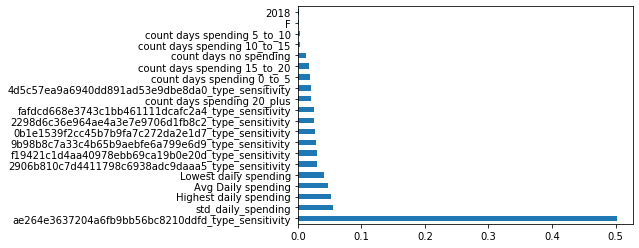

In [6]:
coupon_0_clf = run_predict_random_forest(0, portfolio, profile, target, consumer_feature, consumer_sensitivity)

#### We have found out that `sensitivity` is a really important features, it is determistic to our model.

### 3. Random Forest Classifier on other Target Coupons

Because the multi-label classifier is rather harsh in sklearn, we will perform the same algorithm on each target coupon.

- #### coupon `4d5c57ea9a6940dd891ad53e9dbe8da0`

coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.9386835791945282
accuracy score is 0.9585091420534458
recall score is 0.9090909090909091
precision score is 0.849933598937583
f1 score is 0.8785175017158545
---------------------------------------------------------------


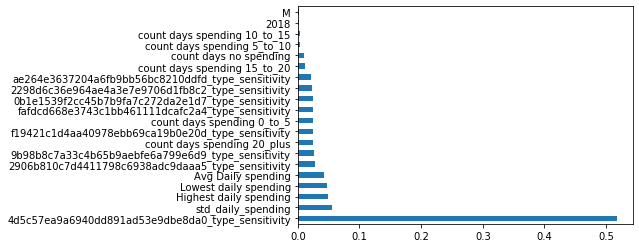

In [7]:
coupon_1_clf = run_predict_random_forest(1, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `9b98b8c7a33c4b65b9aebfe6a799e6d9`

coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.9206513361513542
accuracy score is 0.9538209095171121
recall score is 0.8764044943820225
precision score is 0.7813021702838063
f1 score is 0.8261253309797
---------------------------------------------------------------


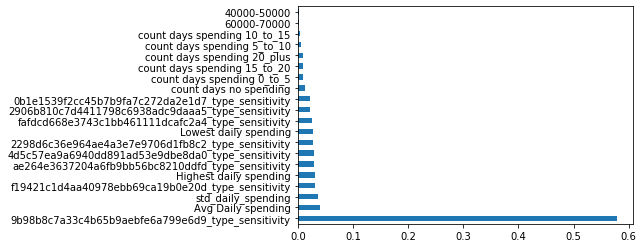

In [8]:
coupon_2_clf =run_predict_random_forest(2, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `0b1e1539f2cc45b7b9fa7c272da2e1d7`

coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.9280079970919666
accuracy score is 0.9676511954992968
recall score is 0.8809523809523809
precision score is 0.751269035532995
f1 score is 0.810958904109589
---------------------------------------------------------------


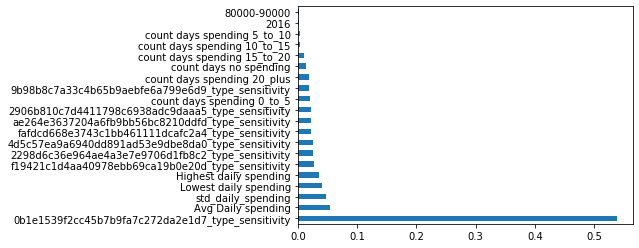

In [9]:
coupon_3_clf = run_predict_random_forest(3, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `2298d6c36e964ae4a3e7e9706d1fb8c2`

coupon 2298d6c36e964ae4a3e7e9706d1fb8c2
roc_auc score is 0.9401621913286359
accuracy score is 0.9503047351148617
recall score is 0.9199623352165726
precision score is 0.884963768115942
f1 score is 0.9021237303785781
---------------------------------------------------------------


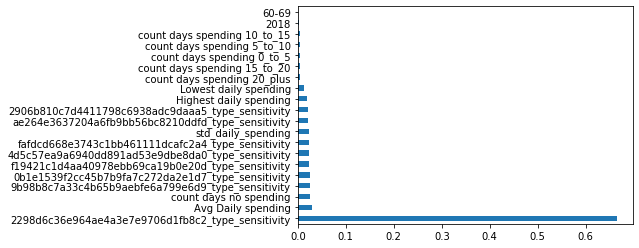

In [10]:
coupon_4_clf = run_predict_random_forest(4, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `fafdcd668e3743c1bb461111dcafc2a4`

coupon fafdcd668e3743c1bb461111dcafc2a4
roc_auc score is 0.9432124921531702
accuracy score is 0.953117674636662
recall score is 0.9231481481481482
precision score is 0.8949730700179533
f1 score is 0.9088422971741112
---------------------------------------------------------------


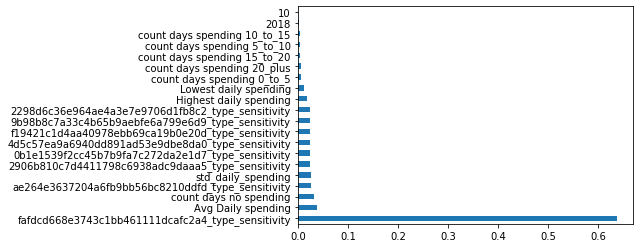

In [11]:
coupon_5_clf = run_predict_random_forest(5, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `f19421c1d4aa40978ebb69ca19b0e20d`

coupon f19421c1d4aa40978ebb69ca19b0e20d
roc_auc score is 0.9287530203382778
accuracy score is 0.9430379746835443
recall score is 0.9042792792792793
precision score is 0.8355879292403746
f1 score is 0.8685776095186588
---------------------------------------------------------------


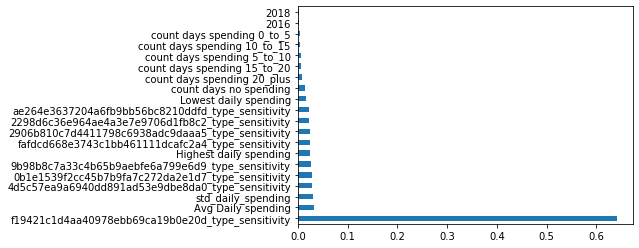

In [12]:
coupon_6_clf = run_predict_random_forest(6, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `2906b810c7d4411798c6938adc9daaa5`

coupon 2906b810c7d4411798c6938adc9daaa5
roc_auc score is 0.9335546104575156
accuracy score is 0.9610876699484294
recall score is 0.8962432915921288
precision score is 0.8226600985221675
f1 score is 0.8578767123287672
---------------------------------------------------------------


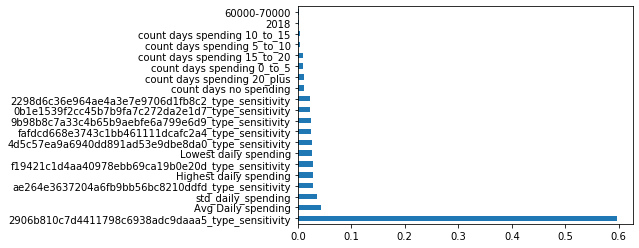

In [13]:
coupon_7_clf = run_predict_random_forest(7, portfolio, profile, target, consumer_feature, consumer_sensitivity)

All the results are looking good (roc_auc 91.7% +), I will skip the hyperopt and jump on to the final wrapping function.

In [20]:
def recommend_coupon_to_consumer(consumer_id):
    
    clf_list = [
        coupon_0_clf,
        coupon_1_clf,
        coupon_2_clf,
        coupon_3_clf,
        coupon_4_clf,
        coupon_5_clf,
        coupon_6_clf,
        coupon_7_clf
    ]
    
    expectations = []
    
    for clf in clf_list:
        
        pred = clf['clf'].predict(clf['consumer_data'].loc[[consumer_id], clf['consumer_data'].columns[1:]])[0]
        difficulty = clf['consumer_data'].loc[consumer_id, 'difficulty']
        roc_auc = clf['roc_auc']
    
        expectations.append(pred * difficulty * roc_auc)
        
    max_i = 0
    max_e = expectations[max_i]
    
    for i, e in enumerate(expectations):
        if e > max_e:
            # update max_i and max_e
            max_i = i
            max_e = e
    
    best = clf_list[max_i]['consumer_data'].columns[0]
    print(f'best coupon for the consumer is: {best}, consumer expected spend is {max_e} ' )
    return best

recommend_coupon_to_consumer('0020ccbbb6d84e358d3414a3ff76cffd')

best coupon for the consumer is: 2298d6c36e964ae4a3e7e9706d1fb8c2, consumer expected spend is 6.5811353393004515 


'2298d6c36e964ae4a3e7e9706d1fb8c2'

## Summary

Now we have the function to recommend coupon to consumer, as long as we have some consumer history data (transcript) to analyse